In [1]:
!cat /proc/meminfo

MemTotal:       65951648 kB
MemFree:        62858352 kB
MemAvailable:   64367600 kB
Buffers:          638196 kB
Cached:          1282252 kB
SwapCached:            0 kB
Active:          1719860 kB
Inactive:         858440 kB
Active(anon):     657856 kB
Inactive(anon):       60 kB
Active(file):    1062004 kB
Inactive(file):   858380 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:                76 kB
Writeback:             0 kB
AnonPages:        657824 kB
Mapped:           146208 kB
Shmem:                72 kB
Slab:             356180 kB
SReclaimable:     313760 kB
SUnreclaim:        42420 kB
KernelStack:        8224 kB
PageTables:         7260 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    32975824 kB
Committed_AS:    2916032 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [1]:
!ls -la /bin

total 7252
dr-xr-xr-x  2 root root    4096 Sep 18 01:14 .
dr-xr-xr-x 26 root root    4096 Oct 24 15:38 ..
-rwxr-xr-x  1 root root   28448 Feb 25  2016 arch
lrwxrwxrwx  1 root root       4 Aug 11 01:26 awk -> gawk
-rwxr-xr-x  1 root root   28128 Feb 25  2016 basename
-rwxr-xr-x  1 root root  936000 Aug 30  2017 bash
-rwxr-xr-x  1 root root   48000 Feb 25  2016 cat
-rwxr-sr-x  1 root cgred  12112 Feb 28  2014 cgclassify
-rwxr-xr-x  1 root root   12744 Feb 28  2014 cgcreate
-rwxr-xr-x  1 root root   11528 Feb 28  2014 cgdelete
-rwxr-sr-x  1 root cgred  12200 Feb 28  2014 cgexec
-rwxr-xr-x  1 root root   15656 Feb 28  2014 cgget
-rwxr-xr-x  1 root root   12464 Feb 28  2014 cgset
-rwxr-xr-x  1 root root   15792 Feb 28  2014 cgsnapshot
-rwxr-xr-x  1 root root   57216 Feb 25  2016 chgrp
-rwxr-xr-x  1 root root   52992 Feb 25  2016 chmod
-rwxr-xr-x  1 root root   58496 Feb 25  2016 chown
-rwxr-xr-x  1 root root  145760 Feb 25  2016 cp
-rwxr-xr-x  1 root root  129912 Oct  8  2014 cpio
-rwxr-xr-

In [48]:
!pip install xgboost msgpack

    100% |████████████████████████████████| 15.8MB 3.3MB/s eta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import io
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)
# from sklearn import preprocessing as prp

# custom functions and objects
from utils import *

# from utils.funcs import predict
# from utils.sample_strategies import stg2_sample, stg2_period_samples, stg2_sample_exclude, rfc_key_features_data

# import xgboost library
import xgboost as xgb

pd.options.display.max_rows = 4000

# ruta de trabajo en s3
bucket = 'boi-banregio'
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV'

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

## Selección de datasets

In [2]:
data1_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/STRATEGY1_PRP.csv"
data1_file_key = "{}/{}".format(prefix, data1_file_name)
data1_obj = s3_bucket_resource.Object(data1_file_key).get()
data1 = pd.read_csv(io.BytesIO(data1_obj['Body'].read()))

In [3]:
data2_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/STRATEGY2_PRP.csv"
data2_file_key = "{}/{}".format(prefix, data2_file_name)
data2_obj = s3_bucket_resource.Object(data2_file_key).get()
data2 = pd.read_csv(io.BytesIO(data2_obj['Body'].read()))

In [4]:
val_data_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/VALIDATION+201705.csv"
val_data_file_key = "{}/{}".format(prefix, val_data_file_name)
val_data_obj = s3_bucket_resource.Object(val_data_file_key).get()
val_data = pd.read_csv(io.BytesIO(val_data_obj['Body'].read()))

In [5]:
extra_features_file_name = 'DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/EXTRA_FEATURES/JAT_MCV_VAR_VARIABLES_DIASATRASO.csv'
extra_features_file_key = "{}/{}".format(prefix, extra_features_file_name)
extra_features_obj = s3_bucket_resource.Object(extra_features_file_key).get()
extra_features_data = pd.read_csv(io.BytesIO(extra_features_obj['Body'].read()))

## Selección de características

In [3]:
feat_sel_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/FEATURE_SELECTION/LASSO_LOGIT.csv"
feat_sel_file_key = "{}/{}".format(prefix, feat_sel_file_name)
feat_sel_obj = s3_bucket_resource.Object(feat_sel_file_key).get()
feat_sel = pd.read_csv(io.BytesIO(feat_sel_obj['Body'].read()))

In [16]:
feature_data_sel = pd.concat(
    [data[feat_sel['Feature']], extra_features_data[stg2_sample].reset_index(drop=True)], 
    axis=1
)
target = data['BMI']

---

In [6]:
feature_data_sel = pd.concat(
    [data1.iloc[:,3:], extra_features_data[stg1_sample].reset_index(drop=True)], 
    axis=1
)
target = data1['BMI']

In [190]:
feature_data_sel = pd.concat(
    [data2.iloc[:,3:], extra_features_data[stg2_sample].reset_index(drop=True)], 
    axis=1
)
target = data2['BMI']

In [164]:
# after feature selection by xgboost importance
feature_data_sel = feature_data_sel[features]

In [7]:
feature_data_sel.shape

(65753, 1914)

## Conjuntos de prueba y entrenamiento

In [8]:
np.random.seed(9)
rand_split = np.random.rand(len(target))
train_list = (rand_split > 0.2)
test_list = rand_split <= 0.2

feature_data_train = feature_data_sel[train_list]
feature_data_test = feature_data_sel[test_list]

target_data_train = target[train_list]
target_data_test = target[test_list]

In [9]:
train_y = target_data_train.values
test_y = target_data_test.values

train_X = feature_data_train.loc[:,:].values
test_X = feature_data_test.loc[:,:].values

dtrain = xgb.DMatrix(
    train_X, 
    label=train_y, 
    feature_names=feature_data_train.columns
)
dtest = xgb.DMatrix(
    test_X, 
    label=test_y, 
    feature_names=feature_data_test.columns
)

## Entrenamiento

In [55]:

# Trianing
version = 0
params = {
    'objective': 'binary:logistic', 
    # 'booster': 'dart',
    'eta':0.3, 
    'max_depth': 5, 
    'eval_metric': 'auc',
    # L1 regularization term (default 0)
    'alpha': 30,
    # L2 regularization term (default 1)
    'lambda': 1,
    # Minimum loss reduction (default 0)
    'gamma': 0.2,
    # 'scale_pos_weight': 7,
    # extremely imbalanced classes
    'max_delta_step': 5,
    # minimum sum of instance weight needed in a child (default 1)
    'min_child_weight': 1
    # 'rate_drop': 0.1,
    # 'skip_drop': 0.5,
    # 'seed': 1 # ,
#     'subsample': 0.5,
#     'max_delta_step': 10    
}

params_BAY = {
    'objective': 'binary:logistic', 
    'eta':0.05,
    'max_depth': 12, 
    'gamma': 0.001, 
    'min_child_weight': 10.108909877670685, 
    'max_delta_step': 2.4592238788322622, 
    'subsample': 1, 
    'colsample_bytree': 0.4,
    'seed': 1
}


num_round = 100

evals = [(dtest, 'eval')]

bst = xgb.train(params, dtrain, num_round, evals, feval=val_func)
# bst = xgb.train(params, dtrain, num_round, evals, feval=val_func, xgb_model=bst)
  
feat_imp = get_xgb_feat_importances(bst)
display(feat_imp)

#pickle.dump(bst, open('models/pickles/cartera_vencida_version{}.pckl.model'.format(version),"wb"))
#feat_imp.to_csv('models/feature_importances_version{}.csv'.format(version), index=False)

[00:46:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-auc:0.764168	eval-f1_score_thr0.2:0.073715	eval-f1_score_thr0.3:0.073715	eval-f1_score_thr0.4:0.438185	eval-f1_score_thr0.5:0.341985	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[00:46:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-auc:0.782041	eval-f1_score_thr0.2:0.073715	eval-f1_score_thr0.3:0.405641	eval-f1_score_thr0.4:0.449629	eval-f1_score_thr0.5:0.391241	eval-f1_score_thr0.6:0.31875	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[00:46:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-auc:0.81511	eval-f1_score_thr0.2:0.360105	eval-f1_score_thr0.3:0.430224	eval-f1_score_thr0.4:0.455668	eval-f1_score_thr0.5:0.395954	eval-f1_score_thr0.6:0.339969	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[00:46:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-auc:0.847696	eval-f1_score_thr0.2:0.41204	eval-f1_score_thr0.3:0.450758	eval-f1_score_thr0.4:0.456311	eval-f1_score_thr0.5:0.413598	eval-f1_score_thr0.6:0.360061	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[00:46:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[4]	eval-auc:0.846532	eval-f1_score_thr0.2:0.423131	eval-f1_score_thr0.3:0.451613	eval-f1_score_thr0.4:0.453634	eval-f1_score_thr0.5:0.411429	eval-f1_score_thr0.6:0.36391	eval-f1_score_thr0.7:0.130435
[00:46:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[5]	eval-auc:0.87487	eval-f1_score_thr0.2:0.45066	eval-f1_score_thr0.3:0.456842	eval-f1_score_thr0.4:0.451531	eval-f1_score_thr0.5:0.415363	eval-f1_score_thr0.6:0.362538	eval-f1_score_thr0.7:0.157143
[00:46:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=5
[6]	eval-auc:0.889057	eval-f1_score_thr0.2:0.4583	eval-f1_score_thr0.3:0.462703	eval-f1_score_thr0.4:0.460358	eval-f1_score_thr0.5:0.415363	eval-f1_score_thr0.6:0.369925	eval-f1_score_thr0.7:0.169611
[00:46:37] /workspace/src/tree

[00:46:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[30]	eval-auc:0.942105	eval-f1_score_thr0.2:0.51463	eval-f1_score_thr0.3:0.508827	eval-f1_score_thr0.4:0.493976	eval-f1_score_thr0.5:0.446237	eval-f1_score_thr0.6:0.390602	eval-f1_score_thr0.7:0.314103
[00:46:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[31]	eval-auc:0.942709	eval-f1_score_thr0.2:0.514236	eval-f1_score_thr0.3:0.508827	eval-f1_score_thr0.4:0.492788	eval-f1_score_thr0.5:0.450402	eval-f1_score_thr0.6:0.394118	eval-f1_score_thr0.7:0.319489
[00:46:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[32]	eval-auc:0.942781	eval-f1_score_thr0.2:0.5189	eval-f1_score_thr0.3:0.50675	eval-f1_score_thr0.4:0.494005	eval-f1_score_thr0.5:0.447721	eval-f1_score_thr0.6:0.385862	eval-f1_score_thr0.7:0.3136
[00:46:55] /workspace/src/tr

[00:47:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[56]	eval-auc:0.946916	eval-f1_score_thr0.2:0.527132	eval-f1_score_thr0.3:0.519211	eval-f1_score_thr0.4:0.494033	eval-f1_score_thr0.5:0.451527	eval-f1_score_thr0.6:0.398827	eval-f1_score_thr0.7:0.333858
[00:47:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[57]	eval-auc:0.946916	eval-f1_score_thr0.2:0.527132	eval-f1_score_thr0.3:0.519211	eval-f1_score_thr0.4:0.494033	eval-f1_score_thr0.5:0.451527	eval-f1_score_thr0.6:0.398827	eval-f1_score_thr0.7:0.333858
[00:47:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[58]	eval-auc:0.946916	eval-f1_score_thr0.2:0.527132	eval-f1_score_thr0.3:0.519211	eval-f1_score_thr0.4:0.494033	eval-f1_score_thr0.5:0.451527	eval-f1_score_thr0.6:0.398827	eval-f1_score_thr0.7:0.333858
[00:47:08] /workspace/src

[00:47:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[82]	eval-auc:0.946916	eval-f1_score_thr0.2:0.527132	eval-f1_score_thr0.3:0.519211	eval-f1_score_thr0.4:0.494033	eval-f1_score_thr0.5:0.451527	eval-f1_score_thr0.6:0.398827	eval-f1_score_thr0.7:0.333858
[00:47:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[83]	eval-auc:0.946916	eval-f1_score_thr0.2:0.527132	eval-f1_score_thr0.3:0.519211	eval-f1_score_thr0.4:0.494033	eval-f1_score_thr0.5:0.451527	eval-f1_score_thr0.6:0.398827	eval-f1_score_thr0.7:0.333858
[00:47:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[84]	eval-auc:0.946916	eval-f1_score_thr0.2:0.527132	eval-f1_score_thr0.3:0.519211	eval-f1_score_thr0.4:0.494033	eval-f1_score_thr0.5:0.451527	eval-f1_score_thr0.6:0.398827	eval-f1_score_thr0.7:0.333858
[00:47:16] /workspace/src

,Feature,Importance
0,DS_CL,0.023143
1,MS_OP,0.023143
2,DIAS_ATRASO,0.018270
3,BK_DEUDA_CP,0.013398
4,MIN_R_BAL_BY_CRED_LIM_12M,0.013398
5,R_BAL_BY_CRED_LIM,0.013398
6,DPCV_CAP,0.012180
7,PCT_BRG_CS_OP_ACC,0.012180
8,AVG_MAX_DIAS_PARA_PAGO_U03M,0.010962
9,PCT_BRG_OP_ACC,0.010962


In [254]:
features = list(feat_imp['Feature'][0:40])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


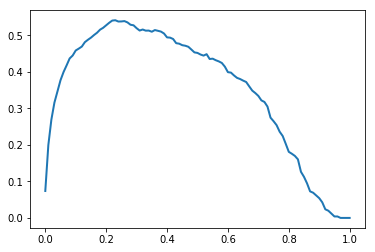

threshold 0.23
max f1_score 0.5409383624655014
eta 0.3
max_depth 5
num_round 100


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


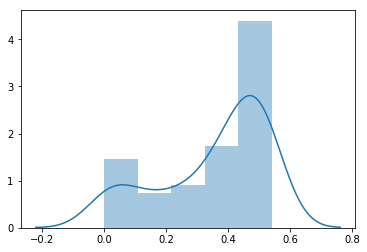

In [56]:
f1_sc = 0
max_step = 0
thr_sample = (dtest, test_y)
_score_preds = bst.predict(thr_sample[0], ntree_limit=bst.best_ntree_limit)
scores = []
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(_score_preds, thr_step)
    f1_sc_step = f1_score(thr_sample[1], _preds)
    #print(thr_step, f1_sc_step)
    scores.append(f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
plt.plot(np.linspace(0, 1, 101), scores, linewidth=2.0)
plt.show()
sns.distplot(scores)

threshold = max_step
print('threshold', threshold)
print('max f1_score', f1_sc)
print('eta', params['eta'])
print('max_depth', params['max_depth'])
print('num_round', bst.best_ntree_limit)

In [12]:
import pickle

missing_cols = pickle.load(open("pickles/stg1_missing_cols.data", "rb")) 
imputer = pickle.load(open("pickles/stg1_imputer.data", "rb"))
scaler = pickle.load(open("pickles/stg1_scaler.data", "rb"))

In [198]:
import pickle

missing_cols = pickle.load(open("pickles/stg2_missing_cols.data", "rb")) 
imputer = pickle.load(open("pickles/stg2_imputer.data", "rb"))
scaler = pickle.load(open("pickles/stg2_scaler.data", "rb"))

In [13]:
val_data = val_data.drop(missing_cols, axis=1)

In [14]:
val_data.iloc[:,3:] = imputer.transform(val_data.iloc[:,3:].values)
val_data.iloc[:,3:] = scaler.transform(val_data.iloc[:,3:].values)

---

In [33]:
validacion = rfc_key_features_data['FECHA'] > 201705
display(validacion.sum())

val_data_sel = pd.concat(
    [val_data[feat_sel['Feature']], extra_features_data[validacion].reset_index(drop=True)], 
    axis=1
)
val_target = val_data['BMI']

82377

---

In [75]:
# local constrain for validation set
local_constrain = (rfc_key_features_data[rfc_key_features_data['FECHA'] > 201705]['FECHA'] == 201711).reset_index(drop=True)

val_data_sel = pd.concat(
    [val_data.iloc[:,3:], extra_features_data[rfc_key_features_data['FECHA'] > 201705].reset_index(drop=True)], 
    axis=1
)[local_constrain]

val_target = val_data[local_constrain]['BMI']

In [76]:
val_y = val_target.values
val_X = val_data_sel.values

dval = xgb.DMatrix(
    val_X, 
    label=val_y, 
    feature_names=val_data_sel.columns
)

In [ ]:
#after feature selection by xgboost importance
val_data_sel = val_data_sel[features]

In [59]:
# make predictions on datasets
train_pred = predict(bst.predict(dtrain), threshold)
test_pred = predict(bst.predict(dtest), threshold)
val_pred = predict(bst.predict(dval), threshold)

cm_train = confusion_matrix(train_y, train_pred)
#cm_train = confusion_matrix(y_resampled, train_pred)
cm_test = confusion_matrix(test_y, test_pred)
cm_val = confusion_matrix(val_y, val_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()*100
cm_test_pct = cm_test / cm_test.astype(np.float).sum()*100
cm_val_pct = cm_val / cm_val.astype(np.float).sum()*100

summary = [
    ['------', 'Train', 'Test', 'Validation'],
    ['confusion matrix', cm_train, cm_test, cm_val],
    ['confusion matrix pct', cm_train_pct, cm_test_pct, cm_val_pct],
    ['f1_score', f1_score(train_y, train_pred), f1_score(test_y, test_pred), f1_score(val_y, val_pred)],    
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(test_y, test_pred), accuracy_score(val_y, val_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(test_y, test_pred), recall_score(val_y, val_pred)],
    ['precision_score', precision_score(train_y, train_pred),  precision_score(test_y, test_pred), precision_score(val_y, val_pred)]
    #['f1_score', f1_score(y_resampled, train_pred), f1_score(test_y, test_pred), f1_score(val_y, val_pred)],
    #['accuracy score', accuracy_score(y_resampled, train_pred), accuracy_score(test_y, test_pred), accuracy_score(val_y, val_pred)],
    #['recall score', recall_score(y_resampled, train_pred), recall_score(test_y, test_pred), recall_score(val_y, val_pred)],
    #['precision_score', precision_score(y_resampled, train_pred),  precision_score(test_y, test_pred), precision_score(val_y, val_pred)]
]

# print pretty table
print('thr', threshold)
print('iter', bst.best_ntree_limit)
pretty_table(summary)
print(params)


thr 0.23
iter 100
------              	Train                      	Test                       	Validation                 
confusion matrix    	[[49560   995]             	[[12325   291]             	[[77017  2083]             
                    	 [  669  1411]]            	 [  208   294]]            	 [ 1583  1694]]            
confusion matrix pct	[[94.15787974  1.89037713] 	[[93.95487117  2.21832596] 	[[93.49332945  2.52861843] 
                    	 [ 1.27101738  2.68072575]]	 [ 1.58560756  2.2411953 ]]	 [ 1.92165289  2.05639924]]
f1_score            	0.6290682122157825         	0.5409383624655014         	0.48029486815990924        
accuracy score      	0.968386054906431          	0.9619606647354779         	0.9554972868640519         
recall score        	0.6783653846153846         	0.5856573705179283         	0.5169362221544095         
precision_score     	0.586450540315877          	0.5025641025641026         	0.4485041037860736         
{'objective': 'binary:logistic', 'eta

In [77]:
# make predictions on datasets

val_pred = predict(bst.predict(dval), threshold)


cm_val = confusion_matrix(val_y, val_pred)

cm_val_pct = cm_val / cm_val.astype(np.float).sum()*100

summary = [
    ['------', 'Validation'],
    ['confusion matrix',  cm_val],
    ['confusion matrix pct',  cm_val_pct],
    ['f1_score',  f1_score(val_y, val_pred)],    
    ['accuracy score',  accuracy_score(val_y, val_pred)],
    ['recall score',  recall_score(val_y, val_pred)],
    ['precision_score',  precision_score(val_y, val_pred)]
]

# print pretty table
print('thr', threshold)
print('iter', bst.best_ntree_limit)
pretty_table(summary)


thr 0.23
iter 100
------              	Validation                 
confusion matrix    	[[13072   312]             
                    	 [  248   260]]            
confusion matrix pct	[[94.0973222   2.24589692] 
                    	 [ 1.78520012  1.87158077]]
f1_score            	0.4814814814814814         
accuracy score      	0.9596890296573568         
recall score        	0.5118110236220472         
precision_score     	0.45454545454545453        
